# Global Imports

In [2]:

import torch
import numpy as np
import matplotlib.pyplot as plt
import os
from einops import rearrange
from torch.utils.data import DataLoader
from torch.optim import AdamW
from torch import nn
from typing import Any
import glob
import re
from datetime import datetime
import random
from collections import defaultdict
from collections import Counter
from torchinfo import summary
from torch.nn.utils.rnn import pad_sequence
import torch
import torch.nn.functional as F
import tqdm
import csv
import os
from datetime import datetime
import tqdm
from sklearn.model_selection import train_test_split
from IPython.display import clear_output
random.seed(42)

# Local Imports

In [3]:
from training.train import EpochLogs, grid_search, LogPoint
from dataset.character_dataset import CharImageDataset
from models.allcnn2d import AllCNN2D
from models.allcnn2d_rnn import CNNRNNModel

# Globals

In [4]:
DEVICE: str = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE: int = 4
DATASET_SPLIT: float = 0.75
MODEL_NAME: str = "KrudLoRA_APL"
LOAD_CHECKPOINT: str = r"C:\Users\Leon\visual-studio\repos\Le-o-n\ocr-model-training\src\cnn_lora\20250409_024444__KrudLoRA_APL__Epoch17_tLoss5.62363_tL12483.67551_tMSE25184.53417_tAcc0.06857_vLoss4.38120_vL12105.55193_vMSE17849.22644_vAcc0.03797.pt"

# Define Paths
Workspace

In [5]:
notebook_dir: str = os.path.abspath(".")
root_dir: str = os.path.join(
    notebook_dir,
    os.pardir,
    os.pardir
)

data_dir: str = os.path.join(
    root_dir,
    "data",
    "apl_lora"
)

model_save_dirpath: str = os.path.join(
    root_dir,
    "models",
    MODEL_NAME
)


Image paths

In [6]:

images_path_glob: str = os.path.join(
    data_dir,
    "u*.png"
)
images_path_regex: str = r"(u[0-9a-f]+)[-]+([0-9a-zA-Z]+)\.png"

image_paths: list[str] = glob.glob(images_path_glob)
random.shuffle(image_paths)

len(image_paths)

1164

# Helper Functions

In [7]:
def get_current_time() -> str:
    return datetime.now().strftime("%Y-%m-%d-%H-%M-%S")


# Logging Setup 

# Extract Labels From File Names

In [8]:


labeled_image_paths: list[tuple[str, str]] = []

class_counts: dict[str, int] = defaultdict(lambda: 0)

file_path: str
for file_path in image_paths:
    match = re.search(images_path_regex, file_path)
    
    if not match:
        continue
    
    u_hexvalue: str = match.group(1)[1:]
    
    char: str = chr(int(u_hexvalue, base=16))
    
    
    class_counts[char] += 1
    
    
    labeled_image_paths.append((char, file_path))

labels: list[str]
image_paths: list[str]
labels, image_paths =  list(zip(*labeled_image_paths))

len(labels), len(image_paths)

(1164, 1164)

In [9]:
Counter(labels)

Counter({'∣': 10,
         '⋄': 10,
         ']': 10,
         ':': 10,
         '⎕': 10,
         '←': 10,
         '⍞': 10,
         '#': 10,
         '"': 10,
         '⍷': 10,
         '⍝': 10,
         '@': 10,
         '`': 10,
         '´': 10,
         '⍣': 10,
         '&': 10,
         '→': 10,
         '^': 10,
         ')': 10,
         '⌶': 8,
         'N': 7,
         '⍫': 7,
         '6': 7,
         'Y': 7,
         '⍬': 7,
         '⌽': 7,
         'G': 7,
         '?': 7,
         '∊': 7,
         '⍺': 7,
         '>': 7,
         'q': 7,
         'X': 7,
         'f': 7,
         '¯': 7,
         'e': 7,
         '⌷': 7,
         '⍨': 7,
         'P': 7,
         'a': 7,
         't': 7,
         '+': 7,
         '!': 7,
         'F': 7,
         'b': 7,
         ';': 7,
         '5': 7,
         'x': 7,
         'j': 7,
         'T': 7,
         '≥': 7,
         '⊥': 7,
         '∩': 7,
         'K': 7,
         'c': 7,
         '=': 7,
         '(': 7,
         '~'

# Balance Classes Using Oversample/Undersample

In [10]:
sorted_counts: list[tuple[str, int]] = sorted(
    class_counts.items(), 
    key=lambda x: x[0]
)

counts: list[int] = [pair[1] for pair in sorted_counts]

max_count: int = max(counts)
min_count: int = min(counts)

to_add_counts: dict[str, int] = {
    uid: max_count - count 
    for uid, count in 
    sorted_counts
}

to_undersample_counts: dict[str, int] = {
    uid: min_count
    for uid, count in 
    sorted_counts
}

total_items = sum(x[1] for x in sorted_counts)


In [11]:
min_count, max_count, total_items

(7, 10, 1164)

In [12]:
#print(*to_add_counts.items())
#print(sorted([(chr(int(pair[0][1:], 16)), pair[1]) for pair in to_remove_counts.items()], key=lambda x: x[1]))

# Oversample

In [13]:
#to_add_labels: list[str] = []
#to_add_file_paths: list[str] = []
#
#while True in [to_add_count>0 for to_add_count in to_add_counts.values()]:  
#    for label, image_path in zip(labels, image_paths):
#        remaining: int = to_add_counts[label]
#        
#        if remaining > 0:
#            to_add_labels.append(label)
#            to_add_file_paths.append(image_path)
#            to_add_counts[label] -= 1

# Undersample

In [14]:
to_keep_labels: list[str] = []
to_keep_file_paths: list[str] = []

while True in [to_add_count>0 for to_add_count in to_undersample_counts.values()]:  
    for label, image_path in zip(labels, image_paths):
        remaining: int = to_undersample_counts[label]
        
        if remaining > 0:
            to_keep_labels.append(label)
            to_keep_file_paths.append(image_path)
            to_undersample_counts[label] -= 1

In [15]:
print(", ".join(to_keep_labels))

N, ⍫, 6, Y, ∣, ⍬, ⌽, G, ⋄, ?, ∊, ], ⍺, >, q, X, f, ¯, e, ⌷, 6, ⍨, P, a, :, t, G, +, !, F, b, ⌶, ⎕, ;, 5, x, j, T, +, ≥, ⍬, ⍺, ⊥, G, a, ∩, K, a, c, =, (, e, q, ~, ←, y, T, \, B, ⍀, ?, ⍴, K, 9, ⍞, o, P, #, ≠, 2, ¨, ⍲, ⌿, ∣, V, F, ↑, b, Q, Y, ", q, ⍷, 9, ⊤, O, ⌶, g, ≠, y, ⍝, ⍎, ., @, `, j, ¨, u, ], ←, ⍋, S, ?, <, A, ¨, ⍱, 5, ⍒, Z, }, \, ´, ·, _, F, ⊂, ., \, ←, S, ↓, `, ⍬, =, ∆, d, h, ∧, ", 6, (, ○, :, Y, ⍳, W, o, e, ∣, ↑, E, +, ;, +, ⍨, ⍒, R, ∣, ', h, <, ×, u, ∧, ⊃, ⍉, ⍫, 3, Y, ", M, V, ·, ⌊, t, ⍳, ⊖, E, ⍣, #, ≥, ○, ⍬, 1, C, %, &, w, ⎕, l, ⊂, ?, ⌽, y, Q, n, |, ∩, ,, ⌿, D, ≠, →, ∪, H, ⍟, ×, ⍝, x, *, W, ⍲, J, ∊, E, ⍫, ∆, ≤, S, -, ", ⍎, O, ⍞, R, ⋄, +, ⍪, D, r, ↑, ⍒, #, &, i, U, ∘, \, X, [, ≠, ⌽, ^, ⌽, ∩, w, b, ↑, s, (, ⍙, I, U, H, ∊, >, ⊃, ∆, ⊥, ⍪, =, ⍴, ⍉, ⌹, →, ⍝, C, J, ⌈, }, N, ∪, #, _, >, ⍣, ⊂, ∘, h, ⍪, ↓, ⍋, n, →, ⎕, J, ', 4, ⍪, S, -, ⌷, ', ≥, ⍳, G, L, M, ≥, *, +, v, ≤, %, ¯, k, :, ∧, ⊣, ∪, 7, f, 5, ≤, ⍣, z, ⍒, ⍣, y, E, =, }, ⍀, 8, R, ∨, ;, @, q, ⍱, 4, _, s, [, 1, t, ⊢, A, 3, ÷, R, ⍎, 0

# Load Dataset

In [16]:
image_paths = to_keep_file_paths
labels = to_keep_labels
len(image_paths), len(labels)

(1106, 1106)

In [17]:

def stratified_split(file_paths, labels, test_size=0.15, val_size=0.15, min_val_samples=1, random_state=42):
    """
    Stratified split with minimum samples per class in all splits
    
    Args:
        file_paths: List of lists of paths - [[class1_paths], [class2_paths], ...]
        labels: List of class labels corresponding to file_paths
        test_size: Proportion for test split
        val_size: Proportion for validation split (relative to remaining after test)
        min_samples: Minimum samples per class in each split (default=1)
    """
    # Flatten structure and create label array
    
    # Convert to numpy arrays
    X = np.array(file_paths)
    y = np.array(labels)
    unique_classes = np.unique(y)
    
    # First split: test with min samples per class
    test_indices = []
    for cls in unique_classes:
        cls_indices = np.where(y == cls)[0]
        n_test = int(test_size * len(cls_indices))
        test_indices.extend(np.random.choice(cls_indices, n_test, replace=False))
    
    # Remaining indices for train/val
    remaining_mask = ~np.isin(np.arange(len(X)), test_indices)
    X_remaining, y_remaining = X[remaining_mask], y[remaining_mask]
    
    # Second split: validation from remaining
    val_indices = []
    for cls in unique_classes:
        cls_indices = np.where(y_remaining == cls)[0]
        n_val = max(min_val_samples, int(val_size * len(cls_indices)))
        val_indices.extend(np.random.choice(cls_indices, n_val, replace=False))
    
    # Final indices
    train_mask = ~np.isin(np.arange(len(X_remaining)), val_indices)
    return (
        X_remaining[train_mask].tolist(), y_remaining[train_mask].tolist(),  # Train
        X_remaining[val_indices].tolist(), y_remaining[val_indices].tolist(),  # Val
        X[test_indices].tolist(), y[test_indices].tolist()  # Test
    )



In [18]:



train_x, train_y, val_x, val_y, test_x, test_y = stratified_split(image_paths, labels, val_size=0, min_val_samples=1, test_size=0)

print(f"Train ({len(train_x)}): {sorted(train_x)} {train_y}")
print(f"Val   ({len(val_x)}): {sorted(val_x)} {val_y}")
print(f"Test  ({len(test_x)}): {sorted(test_x)} {test_y}")

Train (948): ['c:\\Users\\Leon\\visual-studio\\repos\\Le-o-n\\ocr-model-training\\src\\cnn_lora\\..\\..\\data\\apl_lora\\u21-0ba0e7.png', 'c:\\Users\\Leon\\visual-studio\\repos\\Le-o-n\\ocr-model-training\\src\\cnn_lora\\..\\..\\data\\apl_lora\\u21-42642791.png', 'c:\\Users\\Leon\\visual-studio\\repos\\Le-o-n\\ocr-model-training\\src\\cnn_lora\\..\\..\\data\\apl_lora\\u21-42978592.png', 'c:\\Users\\Leon\\visual-studio\\repos\\Le-o-n\\ocr-model-training\\src\\cnn_lora\\..\\..\\data\\apl_lora\\u21-66289430.png', 'c:\\Users\\Leon\\visual-studio\\repos\\Le-o-n\\ocr-model-training\\src\\cnn_lora\\..\\..\\data\\apl_lora\\u21-bfa10e.png', 'c:\\Users\\Leon\\visual-studio\\repos\\Le-o-n\\ocr-model-training\\src\\cnn_lora\\..\\..\\data\\apl_lora\\u21-d84cfa.png', 'c:\\Users\\Leon\\visual-studio\\repos\\Le-o-n\\ocr-model-training\\src\\cnn_lora\\..\\..\\data\\apl_lora\\u2190-55215127.png', 'c:\\Users\\Leon\\visual-studio\\repos\\Le-o-n\\ocr-model-training\\src\\cnn_lora\\..\\..\\data\\apl_lora\\u

In [19]:
all_label_classes = sorted(set(to_keep_labels))
len(all_label_classes)

158

In [20]:
print(','.join(["\'" + str(x) + "\'" for x in all_label_classes]))

'!','"','#','$','%','&',''','(',')','*','+',',','-','.','/','0','1','2','3','4','5','6','7','8','9',':',';','<','=','>','?','@','A','B','C','D','E','F','G','H','I','J','K','L','M','N','O','P','Q','R','S','T','U','V','W','X','Y','Z','[','\',']','^','_','`','a','b','c','d','e','f','g','h','i','j','k','l','m','n','o','p','q','r','s','t','u','v','w','x','y','z','{','|','}','~','£','¨','¯','´','·','×','÷','←','↑','→','↓','∆','∇','∊','∘','∣','∧','∨','∩','∪','≠','≡','≢','≤','≥','⊂','⊃','⊖','⊢','⊣','⊤','⊥','⋄','⌈','⌊','⌶','⌷','⌹','⌽','⌿','⍀','⍉','⍋','⍎','⍒','⍕','⍙','⍝','⍞','⍟','⍣','⍨','⍪','⍫','⍬','⍱','⍲','⍳','⍴','⍵','⍷','⍺','⎕','○'


In [21]:
_old_alphabet = ['(',')','+','-','.','0','1','2','3','4','5','6','7','8','9',':','<','=','>','[',']','a','b','c','d','e','f','g','h','i','j','k','l','m','n','o','p','q','r','s','t','u','v','w','x','y','z','{','}','×','÷','λ']
_new_added_alphabet = [x for x in all_label_classes if x not in _old_alphabet]

all_label_classes = _old_alphabet + _new_added_alphabet

In [22]:

train_char_dataset: CharImageDataset = CharImageDataset(
    file_paths=train_x, #list(image_paths[:split_index]) + to_add_file_paths,
    labels=train_y, #list(labels[:split_index]) + to_add_labels,
    all_label_classes=all_label_classes,
    rotation_limit=0.05,
    translation_limit=0.2,
    skew_limit=0.025,
    zoom_change=1.2,
    min_zoom=0.8,
    thicken_sigma=-4.9,
    image_dims=(64, 64)
)

val_char_dataset: CharImageDataset = CharImageDataset(
    file_paths=val_x,
    labels=val_y,
    all_label_classes=all_label_classes,
    rotation_limit=0.0,
    translation_limit=0.0,
    skew_limit=0.00,
    zoom_change=0.0,
    min_zoom=1.0,
    thicken_sigma=0.0,
    image_dims=(64, 64)
)




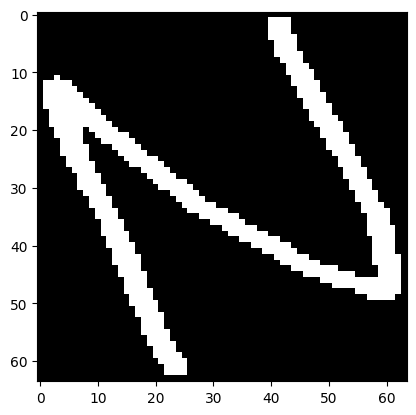

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
N


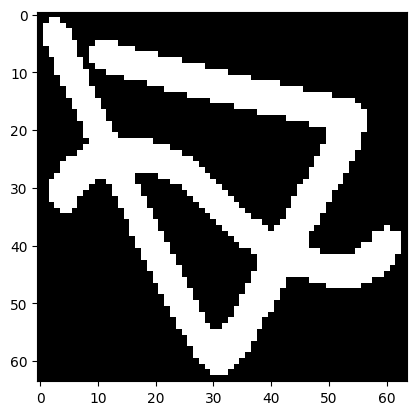

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
⍫


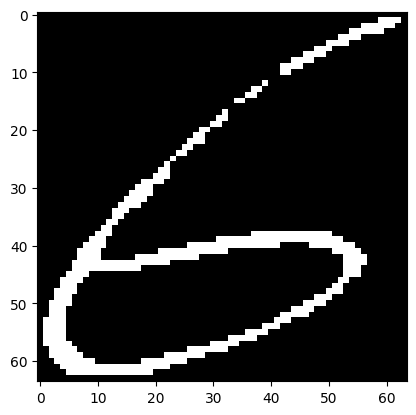

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
6


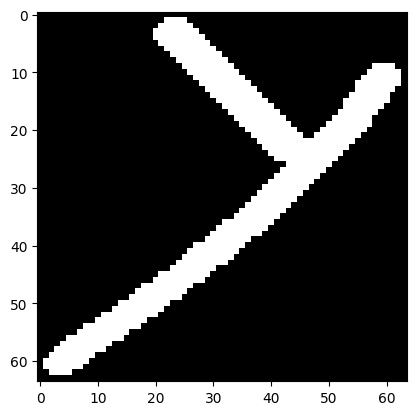

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Y


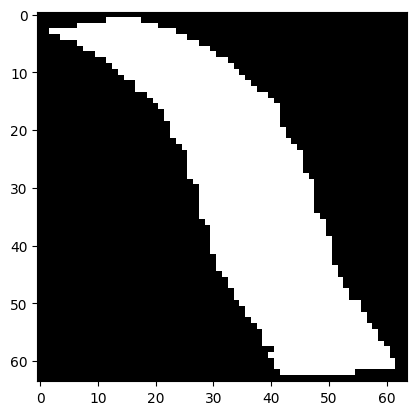

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
∣


In [23]:
for i, (im, lab) in enumerate(train_char_dataset):
    
    
    plt.imshow(
        rearrange(im, "1 h w -> h w")*255, 
        cmap="gray"
    )
    plt.show()
    print(lab)
    print(all_label_classes[np.argmax(lab)])
    if i > 3:
        break


# Load DataLoader

In [24]:
def collate_fn(batch):
    """
    Collate function to pad sequences to the same length.
    """
    # Separate images and labels
    images, labels = zip(*batch)

    # Pad image sequences
    images_padded = pad_sequence(images, batch_first=True, padding_value=0.0)

    # Pad label sequences
    labels_padded = pad_sequence(labels, batch_first=True, padding_value=0.0)

    return images_padded, labels_padded

train_dataloader: DataLoader = DataLoader(
    train_char_dataset,
    shuffle=True,
    batch_size=BATCH_SIZE,
    collate_fn=collate_fn
)

val_dataloader: DataLoader = DataLoader(
    val_char_dataset,
    shuffle=False,
    batch_size=BATCH_SIZE,
    collate_fn=collate_fn
)

# Prepare Pretrained CNN Encoder

In [25]:



cnn_model: nn.Module = AllCNN2D(
    **{
        "conv_features": (1, 16, 32, 32, 32, 32),
        "fully_connected_features": (128, 256),
        "expected_input_size": (64, 64),
        "device": "cuda",
        "conv_dropout": 0.075,
        "verbose": True,
        "name_prefix": MODEL_NAME,
        "checkpoint_path": LOAD_CHECKPOINT,
        "use_lora": False,
        "frozen_layer_prefixes": [
            "encoder_conv_blocks.0", 
            "encoder_conv_blocks.1",
            "encoder_conv_blocks.2", 
            "encoder_conv_blocks.3",
            "encoder_conv_blocks.4.0",
            "encoder_conv_blocks.4.2"
        ],
        "lora_configs": [
            {
                "name": "lora_apl_v2",
                "rank": 4,
                "alpha": 0.1
            }
        ],
        "default_lora_name": "lora_apl_v2"
    }
)


Loaded: encoder_conv_blocks.0.0.weight
Loaded: encoder_conv_blocks.0.0.bias
Loaded: encoder_conv_blocks.0.2.weight
Loaded: encoder_conv_blocks.0.2.bias
Loaded: encoder_conv_blocks.0.2.running_mean
Loaded: encoder_conv_blocks.0.2.running_var
Loaded: encoder_conv_blocks.0.2.num_batches_tracked
Loaded: encoder_conv_blocks.0.4.weight
Loaded: encoder_conv_blocks.0.4.bias
Loaded: encoder_conv_blocks.0.6.weight
Loaded: encoder_conv_blocks.0.6.bias
Loaded: encoder_conv_blocks.0.6.running_mean
Loaded: encoder_conv_blocks.0.6.running_var
Loaded: encoder_conv_blocks.0.6.num_batches_tracked
Loaded: encoder_conv_blocks.1.0.weight
Loaded: encoder_conv_blocks.1.0.bias
Loaded: encoder_conv_blocks.1.2.weight
Loaded: encoder_conv_blocks.1.2.bias
Loaded: encoder_conv_blocks.1.2.running_mean
Loaded: encoder_conv_blocks.1.2.running_var
Loaded: encoder_conv_blocks.1.2.num_batches_tracked
Loaded: encoder_conv_blocks.1.4.weight
Loaded: encoder_conv_blocks.1.4.bias
Loaded: encoder_conv_blocks.1.6.weight
Loaded

# Freeze Non-LoRA Weights

In [26]:
for name, param in cnn_model.named_parameters():
    if not param.requires_grad:
        print(f"[frozen]   {name}")
        continue
    
    print(f"[unfrozen] {name}")

[frozen]   encoder_conv_blocks.0.0.weight
[frozen]   encoder_conv_blocks.0.0.bias
[frozen]   encoder_conv_blocks.0.2.weight
[frozen]   encoder_conv_blocks.0.2.bias
[frozen]   encoder_conv_blocks.0.4.weight
[frozen]   encoder_conv_blocks.0.4.bias
[frozen]   encoder_conv_blocks.0.6.weight
[frozen]   encoder_conv_blocks.0.6.bias
[frozen]   encoder_conv_blocks.1.0.weight
[frozen]   encoder_conv_blocks.1.0.bias
[frozen]   encoder_conv_blocks.1.2.weight
[frozen]   encoder_conv_blocks.1.2.bias
[frozen]   encoder_conv_blocks.1.4.weight
[frozen]   encoder_conv_blocks.1.4.bias
[frozen]   encoder_conv_blocks.1.6.weight
[frozen]   encoder_conv_blocks.1.6.bias
[frozen]   encoder_conv_blocks.2.0.weight
[frozen]   encoder_conv_blocks.2.0.bias
[frozen]   encoder_conv_blocks.2.2.weight
[frozen]   encoder_conv_blocks.2.2.bias
[frozen]   encoder_conv_blocks.2.4.weight
[frozen]   encoder_conv_blocks.2.4.bias
[frozen]   encoder_conv_blocks.2.6.weight
[frozen]   encoder_conv_blocks.2.6.bias
[frozen]   encod

# Train

In [27]:
def l2_regularization(model):
    l2_reg = 0.0
    for param in model.parameters():
        if param.requires_grad:
            l2_reg += torch.sum(param**2)
    return l2_reg

In [28]:



optim: AdamW = AdamW(
    cnn_model.parameters(),
    lr = 0.001,
    weight_decay=5e-3
)

scheduler: torch.optim.lr_scheduler.LRScheduler
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optim,
    T_0=5,
    T_mult=2,
)


In [29]:
l2_regularization(cnn_model) * 5e-3

tensor(2.1467, device='cuda:0', grad_fn=<MulBackward0>)

In [30]:
for name, param in cnn_model.named_parameters():
    if param.requires_grad:
        print(f"[trainable] {name}")
        #print(param)

[trainable] encoder_conv_blocks.4.4.weight
[trainable] encoder_conv_blocks.4.4.bias
[trainable] encoder_conv_blocks.4.6.weight
[trainable] encoder_conv_blocks.4.6.bias
[trainable] fully_connected_blocks.0.0.weight
[trainable] fully_connected_blocks.0.0.bias
[trainable] fully_connected_blocks.1.0.weight
[trainable] fully_connected_blocks.1.0.bias


In [31]:
from models.allcnn2d import LoRALinearWrapper, LoRAConv2DWrapper


for name, module in cnn_model.named_modules():
    if isinstance(module, LoRALinearWrapper) or isinstance(module, LoRAConv2DWrapper):
        print(f"{name}: adapters={list(module.lora_adapters.keys())}, scalings={module.active_scalings}")


In [32]:

# Setup
SESSION_STARTTIME_STR = datetime.now().strftime("%Y%m%d_%H%M%S")
CSV_LOG_FILE = f"{SESSION_STARTTIME_STR}__{MODEL_NAME}__training_metric.csv"

# Write CSV header if file doesn't exist
if not os.path.isfile(CSV_LOG_FILE):
    with open(CSV_LOG_FILE, mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow([
            "epoch",
            "train_loss", "train_l1", "train_mse", "train_acc",
            "val_loss", "val_l1", "val_mse", "val_acc"
        ])

# Training loop
num_epochs = 2000
for epoch in range(num_epochs):
    cnn_model.train()
    train_loss_total: float = 0
    train_l1_total: float = 0
    train_mse_total: float = 0
    train_correct: int = 0
    train_samples: int = 0

    train_loader = tqdm.tqdm(train_dataloader, desc=f"Epoch {epoch+1} - Training", leave=False)
    for X, y in train_loader:
        X: torch.Tensor = X.to(DEVICE)
        y: torch.Tensor = y.to(DEVICE)

        y_pred: torch.Tensor = cnn_model(X)

        y_padded: torch.Tensor = F.pad(y, (0, y_pred.shape[1] - y.shape[1]))

        loss: torch.Tensor = F.cross_entropy(y_pred, y.argmax(dim=1), reduction='sum')
        l1_loss: torch.Tensor = F.l1_loss(y_pred, y_padded, reduction='sum')
        mse_loss: torch.Tensor = F.mse_loss(y_pred, y_padded, reduction='sum')

        
        reg = optim.param_groups[0]["weight_decay"] * l2_regularization(cnn_model) 

        
        loss = loss / X.size(0) + reg
        
        optim.zero_grad()
        loss.backward()
        optim.step()

        

        clear_output()
        
        train_loss_total += loss.item() * X.size(0)
        train_l1_total += l1_loss.item()
        train_mse_total += mse_loss.item()
        
        
        preds = y_pred.argmax(dim=1)
        targets = y.argmax(dim=1).long()
        train_correct += (preds == targets).sum().item()
        train_samples += X.size(0)

        scheduler.step(epoch + train_samples / len(train_dataloader.dataset))

        train_loader.set_postfix({
            "L2Reg": f"{reg:.4f}",
            "Loss (Total)": f"{loss.item():.4f}",
            "Loss (L1)": f"{l1_loss.item()/X.size(0):.4f}",
            "Loss (MSE)": f"{mse_loss.item()/X.size(0):.4f}"
        })

    # Validation
    cnn_model.eval()
    val_loss_total: float = 0
    val_l1_total: float = 0
    val_mse_total: float = 0
    val_correct: int = 0
    val_samples: int = 0

    val_loader = tqdm.tqdm(val_dataloader, desc=f"Epoch {epoch+1} - Validation", leave=False)
    with torch.no_grad():
        
        for X_val, y_val in val_loader:
            X_val: torch.Tensor = X_val.to(DEVICE)
            y_val: torch.Tensor = y_val.to(DEVICE)

            y_val_pred: torch.Tensor = cnn_model(X_val)
            y_val_padded: torch.Tensor = F.pad(y_val, (0, y_val_pred.shape[1] - y_val.shape[1]))

            val_loss: torch.Tensor = F.cross_entropy(y_val_pred, y_val.argmax(dim=1), reduction='sum')
            val_l1: torch.Tensor = F.l1_loss(y_val_pred, y_val_padded, reduction='sum')
            val_mse: torch.Tensor = F.mse_loss(y_val_pred, y_val_padded, reduction='sum')

            val_loss_total += val_loss.item()
            val_l1_total += val_l1.item()
            val_mse_total += val_mse.item()

            val_preds = y_val_pred.argmax(dim=1)
            val_targets = y_val.argmax(dim=1).long()
            val_correct += (val_preds == val_targets).sum().item()
            val_samples += X_val.size(0)

            val_loader.set_postfix({
                "Loss": f"{val_loss.item() / X_val.size(0):.4f}",
                "L1": f"{val_l1.item() / X_val.size(0):.4f}",
                "MSE": f"{val_mse.item() / X_val.size(0):.4f}"
            })
    # Averages
    train_loss_avg = train_loss_total / train_samples if train_samples > 0 else -1
    train_l1_avg = train_l1_total / train_samples if train_samples > 0 else -1
    train_mse_avg = train_mse_total / train_samples if train_samples > 0 else -1
    train_acc = train_correct / train_samples if train_samples > 0 else -1

    val_loss_avg = val_loss_total / val_samples if val_samples > 0 else -1
    val_l1_avg = val_l1_total / val_samples if val_samples > 0 else -1
    val_mse_avg = val_mse_total / val_samples if val_samples > 0 else -1
    val_acc = val_correct / val_samples if val_samples > 0 else -1

    # Save metrics to CSV
    with open(CSV_LOG_FILE, mode='a', newline='') as file:
        writer = csv.writer(file)
        writer.writerow([
            epoch + 1,
            train_loss_avg, train_l1_avg, train_mse_avg, train_acc,
            val_loss_avg, val_l1_avg, val_mse_avg, val_acc
        ])

    # Save model
    model_filename = (
        f"{SESSION_STARTTIME_STR}__{MODEL_NAME}__"
        f"Epoch{epoch+1}_"
        f"tLoss{train_loss_avg:.5f}_tL1{train_l1_avg:.5f}_tMSE{train_mse_avg:.5f}_tAcc{train_acc:.5f}_"
        f"vLoss{val_loss_avg:.5f}_vL1{val_l1_avg:.5f}_vMSE{val_mse_avg:.5f}_vAcc{val_acc:.5f}.pt"
    )
    try:
        print("Saving model")
        torch.save(cnn_model.state_dict(), model_filename)
        print(model_filename)
    except Exception as e:
        print(f"Error skipping... {e}")



Epoch 84 - Training:  14%|█▎        | 32/237 [00:15<01:39,  2.07it/s, L2Reg=0.6352, Loss (Total)=5.3499, Loss (L1)=832.4261, Loss (MSE)=3238.4941]

: 

In [ ]:
cnn_model.state_dict()

OrderedDict([('encoder_conv_blocks.0.0.original.weight',
              tensor([[[[ 0.2740,  0.2949,  0.1547],
                        [-0.2473,  0.1952,  0.0204],
                        [-0.2675,  0.1130,  0.1736]]],
              
              
                      [[[ 0.2254, -0.3073,  0.2675],
                        [-0.1299,  0.0767,  0.2313],
                        [ 0.0535, -0.1954, -0.1494]]],
              
              
                      [[[-0.1853,  0.2320,  0.1130],
                        [ 0.1332, -0.1923,  0.1763],
                        [ 0.1956,  0.3145,  0.1967]]],
              
              
                      [[[-0.1237,  0.2570, -0.0376],
                        [-0.1617,  0.1369,  0.1147],
                        [ 0.1059, -0.1323,  0.2945]]],
              
              
                      [[[ 0.0822, -0.3164,  0.1172],
                        [-0.0444, -0.2802, -0.3248],
                        [ 0.1585, -0.1598, -0.0478]]],
              
   

In [ ]:
for name, module in cnn_model.named_modules():
    if isinstance(module, LoRALinearWrapper):
        for adapter_name, adapter in module.lora_adapters.items():
            A, B = adapter["A"], adapter["B"]
            A_norm = A.norm().item()
            B_norm = B.norm().item()
            print(f"{name}.{adapter_name} → A norm: {A_norm:.4f}, B norm: {B_norm:.4f}, scaling: {module.active_scalings[adapter_name]:.4f}")


fully_connected_blocks.0.0.lora_apl_v1 → A norm: 4.7168, B norm: 6.5293, scaling: 1.0000
fully_connected_blocks.1.0.lora_apl_v1 → A norm: 4.6882, B norm: 11.8058, scaling: 1.0000


In [ ]:
decay_total = 0.0
for name, param in cnn_model.named_parameters():
    if param.requires_grad and param.grad is not None:
        decay_total += (param ** 2).sum().item()

# Multiply by your weight decay value (e.g. from the optimiser)
weight_decay = optim.param_groups[0].get("weight_decay", 0.0)
reg_loss = 0.5 * weight_decay * decay_total

print(f"Regularisation (weight decay) loss: {reg_loss:.4f}")

Regularisation (weight decay) loss: 0.3051


In [ ]:
weight_decay

1e-07

# Inference

In [ ]:
cnn_model: AllCNN2D = AllCNN2D(
    **{
        "conv_features": (1, 16, 32, 32, 32, 32),
        "fully_connected_features": (64, 44),
        "expected_input_size": (64, 64),
        "device": "cuda",
        "conv_dropout": 0.0,#0.075,
        "verbose": True,
        "name_prefix": MODEL_NAME,
        "checkpoint_path": r"C:\Users\Leon\visual-studio\repos\Le-o-n\ocr-model-training\models\allcnn\Indigo_epoch26_trainacc0.71327_valacc0.99057_Tloss0.072851_Vloss0.0056362_lr0.0007224999999999999.pkl"
    }
)

Layer (type:depth-idx)                   Output Shape              Param #
AllCNN2D                                 [1, 44]                   --
├─ModuleList: 1-1                        --                        --
│    └─Sequential: 2-1                   [1, 16, 32, 32]           --
│    │    └─Conv2d: 3-1                  [1, 16, 64, 64]           160
│    │    └─Dropout2d: 3-2               [1, 16, 64, 64]           --
│    │    └─BatchNorm2d: 3-3             [1, 16, 64, 64]           32
│    │    └─LeakyReLU: 3-4               [1, 16, 64, 64]           --
│    │    └─Conv2d: 3-5                  [1, 16, 32, 32]           2,320
│    │    └─Dropout2d: 3-6               [1, 16, 32, 32]           --
│    │    └─BatchNorm2d: 3-7             [1, 16, 32, 32]           32
│    │    └─LeakyReLU: 3-8               [1, 16, 32, 32]           --
│    └─Sequential: 2-2                   [1, 32, 16, 16]           --
│    │    └─Conv2d: 3-9                  [1, 32, 32, 32]           4,640
│    │  

Layer (type:depth-idx)                   Param #
AllCNN2D                                 --
├─ModuleList: 1-1                        --
│    └─Sequential: 2-1                   --
│    │    └─Conv2d: 3-1                  160
│    │    └─Dropout2d: 3-2               --
│    │    └─BatchNorm2d: 3-3             32
│    │    └─LeakyReLU: 3-4               --
│    │    └─Conv2d: 3-5                  2,320
│    │    └─Dropout2d: 3-6               --
│    │    └─BatchNorm2d: 3-7             32
│    │    └─LeakyReLU: 3-8               --
│    └─Sequential: 2-2                   --
│    │    └─Conv2d: 3-9                  4,640
│    │    └─Dropout2d: 3-10              --
│    │    └─BatchNorm2d: 3-11            64
│    │    └─LeakyReLU: 3-12              --
│    │    └─Conv2d: 3-13                 9,248
│    │    └─Dropout2d: 3-14              --
│    │    └─BatchNorm2d: 3-15            64
│    │    └─LeakyReLU: 3-16              --
│    └─Sequential: 2-3                   --
│    │    └─Conv2

In [ ]:
for char, label in val_char_dataset:
    plt.imshow(char[0, :, :])
    plt.show()
    pred: torch.Tensor = model.forward(char.unsqueeze(0)).squeeze()
    pred_index: int = torch.argmax(pred).item()
    print(chr(int(all_label_classes[pred_index][1:], base=16)))

TypeError: pad() got an unexpected keyword argument 'mode'